# ABTest数据分析应用案例
abtest数据的离线分析也是notebook的高频场景，本案例介绍
1. AB指标的提取
2. AB指标的分析及可视化：维度聚合、指标派生（均值、比率等计算）、可视化
3. AB指标的回溯计算/新指标的计算（进行中实验、已结束实验）
3. AB指标的置信分析（TTest）
4. AB指标的DID(双重差分)分析

## AB实验数据的提取
1. 提取AB实验数据需要了解的基本概念：世界、实验、指标数据源、指标
2. 提取AB指标数据
3. 提取AB实验明细数据

In [9]:
# 数据探查
import myutil
import pandas as pd 

# 获取表头信息
head_sql = sql = u'''desc ks_strategy.abtest_core_metrics_crash  
'''
head_row = myutil.query_hive(head_sql,maxrow=100)

head_df = pd.DataFrame(head_row)

# 数据采样
sql = u'''select * from ks_strategy.abtest_core_metrics_crash  
where p_date = '20200501'  limit 10
'''
rows = myutil.query_hive(sql,maxrow=100,)

# 探索数据
explorer_df = pd.DataFrame(rows,columns=head_df[0][0:13])
explorer_df.head(10) # 数据探查，定位需要的字段

get result from local cache /home/public/.hiveutil/cache/ae/ae2378cecc733b0c5a68e238c58405b03aa84bc0 0.0MB
get result from local cache /home/public/.hiveutil/cache/f1/f1ae5c00d41f45ff41edef14e6944b90738de2ad 0.0MB


,world_name,exp_name,group_name,time_tag,app_platform,app_version,java_crash_user_cnt,java_crash_cnt,native_crash_user_cnt,native_crash_cnt,anr_user_cnt,anr_cnt,p_date
0,ad_social_0,None,None,1588305600,android,6.11.1.11967,0,0,0,0,3,3,20200501
1,ad_social_0,None,None,1588305600,android,6.11.6.12266,0,0,1,1,8,16,20200501
2,ad_social_0,None,None,1588305600,android,6.7.1.10259,0,0,0,0,1,2,20200501
3,ad_social_0,None,None,1588305600,android,7.0.0.12320,0,0,0,0,3,5,20200501
4,ad_social_0,None,None,1588305600,android,7.0.0.12395,0,0,3,3,21,43,20200501
5,ad_social_0,None,None,1588305600,android,7.1.0.12396,0,0,0,0,3,4,20200501
6,ad_social_0,None,None,1588305600,android,7.3.10.13266,0,0,3,3,27,44,20200501
7,ad_social_0,None,None,1588305600,android,7.3.20.13568,6,14,19,26,68,143,20200501
8,ad_social_0,None,None,1588305600,ios,6.6.2.1004,82,90,98,190,5,51,20200501
9,ad_social_0,None,None,1588305600,unknown,5.10.4.734,1,2,0,0,4,157,20200501


In [34]:
# 通过world、exp定位需要的指标数据
sql = u'''select * from ks_strategy.abtest_core_metrics_crash  
where p_date between  '20200501' and '20200509'  and world_name = 'mille_gray_release_0' and exp_name = 'cursorWindowSize'
'''
rows = myutil.query_hive(sql,maxrow=1000000,cache=True)

# 探索数据
explorer_df = pd.DataFrame(rows,columns=head_df[0][0:13])
explorer_df.head(10) # 数据探查，定位需要的字段

get result from local cache /home/public/.hiveutil/cache/9b/9b25c2a71860a818e16cf0d7b266c6782052db92 14.36MB


,world_name,exp_name,group_name,time_tag,app_platform,app_version,java_crash_user_cnt,java_crash_cnt,native_crash_user_cnt,native_crash_cnt,anr_user_cnt,anr_cnt,p_date
0,mille_gray_release_0,cursorWindowSize,base1,1588305600,android,5.8.8.6704,0,0,1,4,0,0,20200501
1,mille_gray_release_0,cursorWindowSize,base1,1588305600,android,6.11.6.12269,0,0,0,0,1,4,20200501
2,mille_gray_release_0,cursorWindowSize,base1,1588305600,android,7.3.10.13582,11,17,20,25,85,152,20200501
3,mille_gray_release_0,cursorWindowSize,base1,1588305600,android,7.3.30.13629,0,0,0,0,2,17,20200501
4,mille_gray_release_0,cursorWindowSize,base2,1588305600,ios,7.3.10.1755,1,1,1,1,0,0,20200501
5,mille_gray_release_0,cursorWindowSize,base3,1588305600,android,6.10.1.11769,0,0,1,2,0,0,20200501
6,mille_gray_release_0,cursorWindowSize,base3,1588305600,android,6.8.2.10841,0,0,1,1,1,1,20200501
7,mille_gray_release_0,cursorWindowSize,base3,1588305600,android,7.2.4.13274,0,0,1,2,6,25,20200501
8,mille_gray_release_0,cursorWindowSize,base3,1588305600,ios,5.6.8.447,4,7,0,0,7,53,20200501
9,mille_gray_release_0,cursorWindowSize,base3,1588305600,ios,5.8.7.620,1,1,0,0,13,88,20200501


## AB指标的分析和可视化

In [63]:
# 指标数据的后续加工：维度聚合、复合计算
gb_df = explorer_df.groupby(['p_date','group_name'])['java_crash_user_cnt','java_crash_cnt','native_crash_user_cnt','native_crash_cnt'].sum()

In [112]:
# pivot 数据透视1   注意透视的时候 数据轴的选择 主要是 index column values 以及 聚合方法
pivot_df = pd.pivot_table(df,index=['p_date'], columns=['group_name'],values=['java_crash_user_cnt','java_crash_cnt','native_crash_user_cnt','native_crash_cnt'] ,aggfunc=sum)
pivot_df.head(3)

0          java_crash_cnt                                                     \
group_name          base1 base2  base3  base4  exp1  exp2  exp3  exp4   exp5   
p_date                                                                         
20200501             6682  6841  64483  63681  6605  6336  6113  5803  63953   
20200502             6616  6623  65834  62297  6276  5891  5761  5544  62075   
20200503             5684  7744  60445  60706  5995  5679  5676  5643  59903   

0                   ...   native_crash_user_cnt                               \
group_name   exp6   ...                   base3   base4   exp1   exp2   exp3   
p_date              ...                                                        
20200501    62111   ...                  106180  105769  10612  10619  10566   
20200502    60815   ...                  102661  103156  10354  10265  10439   
20200503    59398   ...                  101707  101499  10385  10196  10237   

0                                                  
group_name   exp4    exp5    exp6    exp7    exp8  
p_date                                             
20200501    10653  105746  106254  105661  106170  
20200502    10250  102736  103239  103239  102571  
20200503    10223  101634  101704  101071  101438  

[3 rows x 48 columns]

In [147]:
# 聚合数据之间可以通过 stack 方法转换
pivot_df3 = pivot_df.stack()   # 列的内存索引堆叠到行索引中 此时两种透视数据一致
#pivot_df2 = pd.pivot_table(df,index=['p_date','group_name'],values=['java_crash_user_cnt','java_crash_cnt','native_crash_user_cnt','native_crash_cnt'] ,aggfunc=sum)
#pivot_df = pd.pivot_table(df,index=['p_date'], columns=['group_name'],values=['java_crash_user_cnt','java_crash_cnt','native_crash_user_cnt','native_crash_cnt'] ,aggfunc=sum)

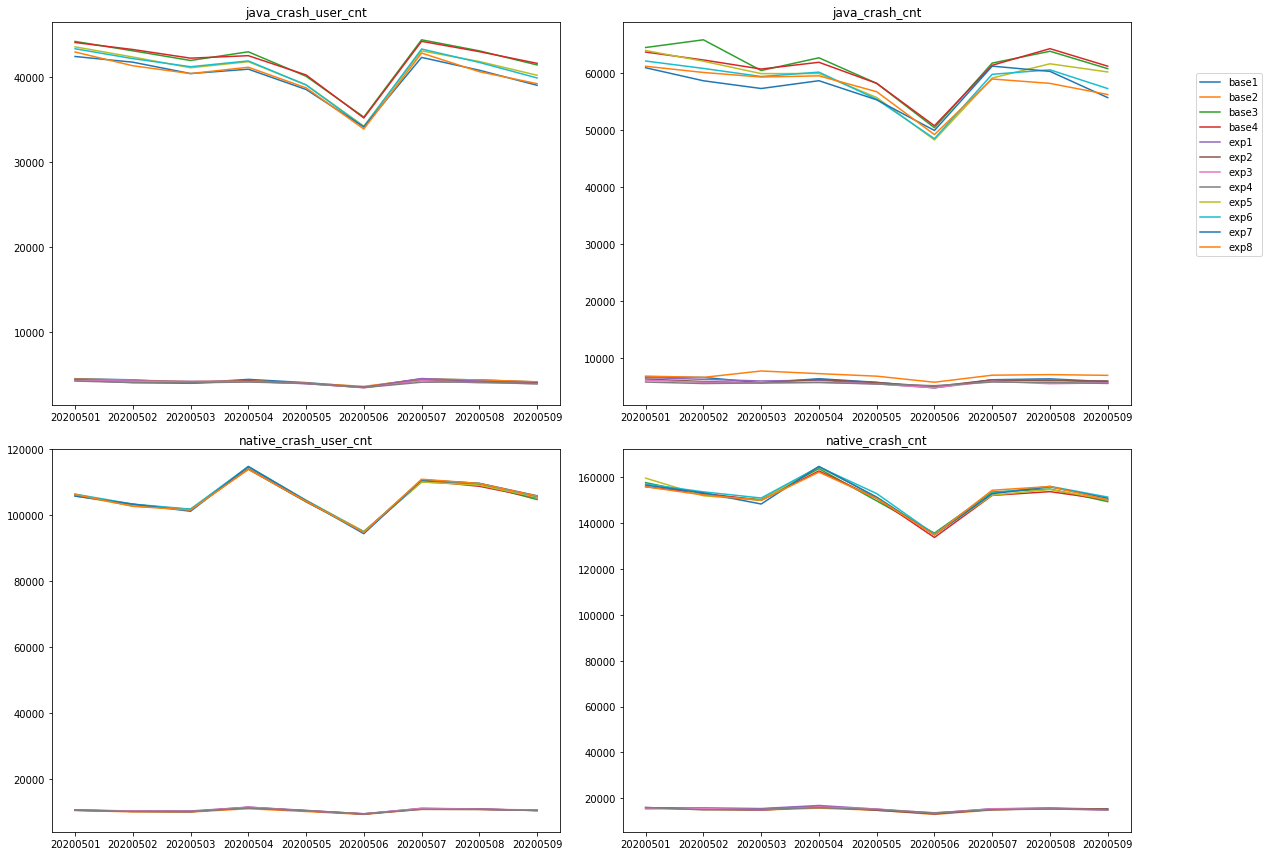

In [97]:
# 指标时序图
import matplotlib.pyplot as plt
import numpy as np
from plotly.offline import iplot

fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 0), rowspan=1, colspan=1)
ax4 = plt.subplot2grid((2, 2), (1, 1), rowspan=1, colspan=1)

ax1.plot(pivot_df['java_crash_user_cnt'])
ax1.set_title('java_crash_user_cnt')
ax2.plot(pivot_df['java_crash_cnt'])
ax2.set_title('java_crash_cnt')
ax3.plot(pivot_df['native_crash_user_cnt'])
ax3.set_title('native_crash_user_cnt')
ax4.plot(pivot_df['native_crash_cnt'])
ax4.set_title('native_crash_cnt')


#handles, labels = ax1.get_legend_handles_labels()
fig.legend(pivot_df['java_crash_user_cnt'].columns, loc='center right' , bbox_to_anchor=(1.1, 0.8))


plt.tight_layout()
plt.show()

In [116]:
pivot_df.head(3)

0          java_crash_cnt                                                     \
group_name          base1 base2  base3  base4  exp1  exp2  exp3  exp4   exp5   
p_date                                                                         
20200501             6682  6841  64483  63681  6605  6336  6113  5803  63953   
20200502             6616  6623  65834  62297  6276  5891  5761  5544  62075   
20200503             5684  7744  60445  60706  5995  5679  5676  5643  59903   

0                   ...   native_crash_user_cnt                               \
group_name   exp6   ...                   base3   base4   exp1   exp2   exp3   
p_date              ...                                                        
20200501    62111   ...                  106180  105769  10612  10619  10566   
20200502    60815   ...                  102661  103156  10354  10265  10439   
20200503    59398   ...                  101707  101499  10385  10196  10237   

0                                                  
group_name   exp4    exp5    exp6    exp7    exp8  
p_date                                             
20200501    10653  105746  106254  105661  106170  
20200502    10250  102736  103239  103239  102571  
20200503    10223  101634  101704  101071  101438  

[3 rows x 48 columns]

<Figure size 432x288 with 0 Axes>

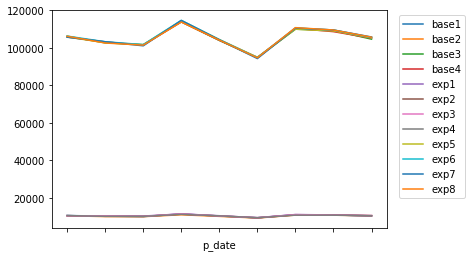

In [180]:
# 逐个指标分析 native_crash_user_cnt
df_1  = pivot_df['native_crash_user_cnt']

plt.figure()
df_1.plot()
plt.legend(loc=1,bbox_to_anchor=(1.25, 1))  

<Figure size 432x288 with 0 Axes>

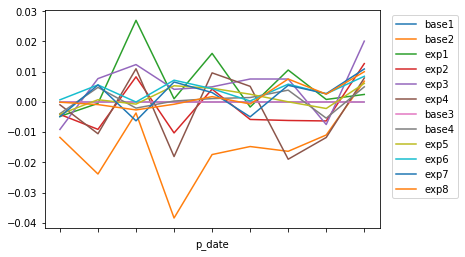

In [181]:
# 查看指标波动
df1_diff = df_1[['base1','base2','exp1','exp2','exp3','exp4']].apply(lambda x : (x- df_1['base1']) / df_1['base1'])
df1_diff[['base3','base4','exp5','exp6','exp7','exp8']] = df_1[['base3','base4','exp5','exp6','exp7','exp8']].apply(lambda x : (x- df_1['base3']) / df_1['base3'])


plt.figure()
df1_diff.plot()
plt.legend(loc=1,bbox_to_anchor=(1.25, 1))  

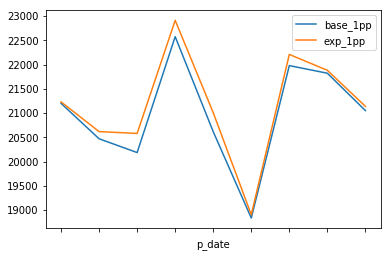

In [185]:
# 各分组数的合并 base1pp exp1pp base10pp exp10pp
df_2 = pd.DataFrame()
df_2['base_1pp'] = df_1['base1'] + df_1['base2']
df_2['exp_1pp'] = df_1['exp1'] + df_1['exp2']
df_2.plot()

## AB指标的回溯计算/新指标的计算（进行中实验、已结束实验）
这里进行指标聚合的时候需要使用abtest发布的udf jar包
$\color{red}{明细数据抽取涉及权限这里仅做示例}$

In [76]:
import myutil
# 注意通过myutil或者pyhive提交sql执行的时候不能出现 ;  所有的sql单独执行，如下

myutil.execute_hive('set hive.smart.router.enable=false')
myutil.execute_hive('set hive.execution.engine=mr')
myutil.execute_hive('set beacon.conf.var.reset.enable=true')
myutil.execute_hive('set beacon.semantic.analyzer.limitsuffix.number=10000000')
myutil.execute_hive('set hive.groupby.orderby.position.alias=true')
# 进行中实验分组查询
myutil.execute_hive('delete jar viewfs:///home/system/hive/resources/abtest/kuaishou-abtest-udf-latest.jar')
myutil.execute_hive('add jar viewfs:///home/system/hive/resources/abtest/kuaishou-abtest-udf-latest.jar')
myutil.execute_hive("CREATE TEMPORARY FUNCTION lookupCurrentExp as 'com.kuaishou.abtest.udf.LookupCurrentExp'")
myutil.execute_hive("CREATE TEMPORARY FUNCTION lookupCurrentGroup as 'com.kuaishou.abtest.udf.LookupCurrentGroup'")
# 已结束实验分组查询
myutil.execute_hive("create temporary function lookupVersionedExp as 'com.kuaishou.abtest.udf.LookupVersionedExp'")
myutil.execute_hive("create temporary function lookupVersionedGroup as 'com.kuaishou.abtest.udf.LookupVersionedGroup'")



In [ ]:
# 指标回溯计算，通常在指标口径有变化情况或者新的指标计算时使用； 注意进行中的ab实验和已经结束的ab实验使用不同的udf函数：lookupCurrentExp    LookupVersionedExp
# 返回的 metric_result 和 直接查询 指标表中数据一致

columns = ['p_date','world_name','exp_name','group_name','crash_cnt','crash_device_cnt','native_crash_cnt','native_crash_device_cnt','anr_cnt','anr_device_cnt','anr_monitor_launch_cnt','anr_monitor_launch_device_cnt','launch_count','launch_device_cnt']

metric_sql = '''  
SELECT
TA.p_date,
TA.world_name,
TA.exp_name,
TA.group_name,
crash_cnt,
crash_device_cnt,
native_crash_cnt,
native_crash_device_cnt,
anr_cnt,
anr_device_cnt,
anr_monitor_launch_cnt,
anr_monitor_launch_device_cnt,
launch_count,
launch_device_cnt
FROM (
    SELECT
        p_date,
        world_name,
        exp_name,
        group_name,
        sum(if(exception_type='CRASH', 1, 0)) AS crash_device_cnt,
        sum(if(exception_type='CRASH', cnt, 0)) AS crash_cnt,
        sum(if(exception_type='NATIVE_CRASH', 1, 0)) AS native_crash_device_cnt,
        sum(if(exception_type='NATIVE_CRASH', cnt, 0)) AS native_crash_cnt,
        sum(if(exception_type='ANR', 1, 0)) AS anr_device_cnt,
        sum(if(exception_type='ANR', cnt, 0)) AS anr_cnt
    FROM (
        SELECT
            p_date,
            world_name,
            exp_name,
            group_name,
            exception_type,
            identity_device_id,
            device_model,            
            count(1) AS cnt
        FROM (
            SELECT
                p_date,
                app_version_name,
                app_package_name,
                device_os_version,
                if(app_platform = 'ANDROID_PHONE', 'android', 'ios') AS platform,
                exception_type,
                identity_device_id,
                device_model,
                'mille_gray_release_0' as world_name,
                lookupCurrentExp('mille_gray_release_0',CAST(identity_user_id AS bigint),identity_device_id) AS exp_name,
                lookupCurrentGroup('mille_gray_release_0',CAST(identity_user_id AS bigint),identity_device_id) AS group_name
            FROM ks_client_log_v2.exception_event
            WHERE p_date BETWEEN '20200501' AND '20200507'
  AND app_product='KUAISHOU'
  AND (app_platform = 'ANDROID_PHONE'
       AND app_channel NOT RLIKE 'TEST'
       AND app_version_code != 9999)
  AND exception_type IN ('CRASH',
                         'NATIVE_CRASH',
                         'ANR')
  AND app_version_name="7.3.30.13554"
  AND lookupCurrentExp('mille_gray_release_0',CAST(identity_user_id AS bigint),identity_device_id)='cursorWindowSize'
        ) AS exception
        GROUP BY
        p_date,world_name,exp_name,group_name,exception_type,identity_device_id,device_model
    ) AS exception_aggr
    GROUP BY
        p_date,
        world_name,
        exp_name,
        group_name
) AS TA
LEFT JOIN (
    SELECT
        p_date,
        world_name,
        exp_name,
        group_name,
        sum(cnt) AS launch_count,
        sum(1) AS launch_device_cnt,
        sum(anr_monitor_launch_cnt) as anr_monitor_launch_cnt,
        sum(if(anr_monitor_launch_cnt>0,1,0)) as anr_monitor_launch_device_cnt
    FROM (
        SELECT
            p_date,
            world_name,
            exp_name,
            group_name,
            identity_device_id,
            sum(anr_monitor_launch_cnt) as anr_monitor_launch_cnt,
            device_model,
            count(1) AS cnt
        FROM (   
            SELECT
                p_date,
                identity_device_id,
                if(array_contains(split(experiment,'\"'),'anrMonitor'),1,0) as anr_monitor_launch_cnt,
                device_model,
                'mille_gray_release_0' as world_name,
                lookupCurrentExp('mille_gray_release_0',CAST(identity_user_id AS bigint),identity_device_id) AS exp_name,
                lookupCurrentGroup('mille_gray_release_0',CAST(identity_user_id AS bigint),identity_device_id) AS group_name
            FROM ks_client_log_v2.launch_event
            WHERE p_date BETWEEN '20200501' AND '20200507'
                AND (app_platform = 'ANDROID_PHONE' AND app_channel NOT RLIKE 'TEST' AND app_version_code != 9999)
                AND launch_time_cost >= 0 AND launch_time_cost <= 60 * 1000
                and  app_version_name="7.3.30.13554"
                and  lookupCurrentExp('mille_gray_release_0',CAST(identity_user_id AS bigint),identity_device_id)='cursorWindowSize'
            ) AS launch   
        GROUP BY p_date,
            world_name,
            exp_name,
            group_name,
            identity_device_id,
            device_model
    ) AS launch_aggr
    GROUP BY  p_date,
        world_name,
        exp_name,
        group_name
) AS TB
ON TA.p_date = TB.p_date
AND TA.world_name = TB.world_name
AND TA.exp_name=TB.exp_name
AND TA.group_name=TB.group_name
'''

metric_result = myutil.lazy_query(metric_sql, columns = columns)

## AB指标的置信分析  TTest
ttest进行置信分析，可以参考案例： https://jupyter-share.corp.kuaishou.com/user/hezan/notebooks/demo/TTest_demo.ipynb
</br>
$\color{red}{处理的时候注意抽取的dataframe数据和样例数据格式的一致性}$

In [1]:
# 使用明细数据进行ttest （treatment及group_name） 
#导入路径内的DID包和需要的pandas包
import sys
sys.path.append('/home/public/benyuansong')
from DID import preprocessing,ttest
import pandas as pd                                     

#读取分析文件
file = pd.read_csv('/home/demo/data/ztest_sample2.csv')   
file.head(5)



,date,treatment,groupname,post,user_id,birthday,fans_range,acu_range,live_duration,receive_amount,receive_cnt,receive_gift_cnt
0,20190511,1,exp2,0,45552,525,1w-10w,10-100,381.283333,7,3,3
1,20190510,1,exp2,0,45552,525,1w-10w,10-100,394.250000,8,8,8
2,20190516,1,exp2,0,45552,525,1w-10w,10-100,179.166667,0,0,0
3,20190513,1,exp2,0,45552,525,1w-10w,10-100,384.866667,45,18,18
4,20190515,1,exp2,0,45552,525,1w-10w,10-100,357.733333,0,0,0


In [ ]:
# 获取实验明细数据，结构类似 ttest中的demo数据 file文件； 这里我们可以使用 

fact_columns = ['p_date','world_name',     'exp_name', 'group_name',  'identity_device_id',
               'crash_device_cnt','crash_cnt',  'native_crash_device_cnt',  'native_crash_cnt', 'anr_device_cnt','anr_cnt']
fact_sql ='''
SSELECT
        p_date,
        world_name,
        exp_name,
        group_name, identity_device_id,
        sum(if(exception_type='CRASH', 1, 0)) AS crash_device_cnt,
        sum(if(exception_type='CRASH', cnt, 0)) AS crash_cnt,
        sum(if(exception_type='NATIVE_CRASH', 1, 0)) AS native_crash_device_cnt,
        sum(if(exception_type='NATIVE_CRASH', cnt, 0)) AS native_crash_cnt,
        sum(if(exception_type='ANR', 1, 0)) AS anr_device_cnt,
        sum(if(exception_type='ANR', cnt, 0)) AS anr_cnt
    FROM (
        SELECT
            p_date,
            world_name,
            exp_name,
            group_name,
            exception_type,
            identity_device_id,
            device_model,            
            count(1) AS cnt
        FROM (
            SELECT
                p_date,
                app_version_name,
                app_package_name,
                device_os_version,
                if(app_platform = 'ANDROID_PHONE', 'android', 'ios') AS platform,
                exception_type,
                identity_device_id,
                device_model,
                'mille_gray_release_0' as world_name,
                lookupCurrentExp('mille_gray_release_0',CAST(identity_user_id AS bigint),identity_device_id) AS exp_name,
                lookupCurrentGroup('mille_gray_release_0',CAST(identity_user_id AS bigint),identity_device_id) AS group_name
            FROM ks_client_log_v2.exception_event
            WHERE p_date BETWEEN '20200501' AND '20200507'
  AND app_product='KUAISHOU'
  AND (app_platform = 'ANDROID_PHONE'
       AND app_channel NOT RLIKE 'TEST'
       AND app_version_code != 9999)
  AND exception_type IN ('CRASH',
                         'NATIVE_CRASH',
                         'ANR')
  AND app_version_name="7.3.30.13554"
  AND lookupCurrentExp('mille_gray_release_0',CAST(identity_user_id AS bigint),identity_device_id)='cursorWindowSize'
        ) AS exception
        GROUP BY
        p_date,world_name,exp_name,group_name,exception_type,identity_device_id,device_model
       ) AS exception_aggr
    GROUP BY
        p_date,
        world_name,
        exp_name,
        group_name,  identity_device_id
       '''
fact_result  = myutil.lazy_query(fact_sql, columns = fact_columns)

In [2]:
# 将ttest demo数据file 修改为上面查询得到的 fact_result
file = file.drop(['treatment'],axis=1)  
#对file进行预处理，参数从左到右依次为dataframe数据、分析的y变量、组别字段名、user字段名、treatment字段中base组的值（因为至少有两个base组，所以是列表形式表示）、treatment中exp组的值
base1,base2,exp = preprocessing.ttest_preprocessing(file, 'live_duration', treatment_col = 'groupname', name_col = 'user_id',basename=['base1','base2'],expname='exp1')


#打印ttest结果，包括差异是否显著，如果显著，那么差异是多少。参数从左到右依次为：base1数据源、base2数据源、exp数据源、分析的y变量、method='log'代表返回的差异是百分比，默认是None，返回差异是平均值的差
ttest.ttest(base1,base2,exp,'live_duration')

live_duration: ab_pvalue:0.32539901685976513,difference(exp-base):1.2225426754047106,Percentage of increase:1.90%


## AB指标的DID分析
可以参考案例： https://jupyter-share.corp.kuaishou.com/user/hezan/notebooks/demo/DID_demo.ipynb

</br>
$\color{red}{处理的时候注意抽取的dataframe数据和样例数据格式的一致性}$

In [ ]:
# 使用明细数据做did分析

# 示例数据
file = pd.read_csv('/home/public/ks_live_stream/live_chat_author_data_20190213_v1.csv')
outcome = ['live_stream_cnt','live_stream_duration','total_watching_duration','receive_amount','like_cnt','comment_cnt','share_cnt','pk_cnt','voice_comment_cnt']

# 数据预处理
file = preprocessing.did_preprocessing(file, treatment_col = 'treatment', name_col = 'user_id', date_col = 'live_date')

# 算法匹配，可跳过
#did.algorithm_show(file, 3, -11, by_treatment=False, label='if_on')

# 样本matching
matched,pscore,match_id,feature_importance=did.matching(file, 3, -11, model='LightGBM', by_treatment=False ,label='if_on', caliper=0.05,top=10)
feature_importance
#CEM匹配： matched = did.CEM(file, 3, -11, cutpoints = None, grouping = None, is_K2K=False, break_method = 'sturges')

# 平行趋势检验
did.check_parallel(matched, outcome, '2018-12-11', step = 1)

# 平衡检查
did.check_covariate_balance(matched,feature_importance['column'])

# did结果及可视化
did.result(matched,outcome,'2018-12-11')
did.plotResult(matched[matched.gender=='M'], outcome, step = 5) 
